**IMPORTS**


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')

# Import the library
from option_library import (
    # Dynamics models
    create_dynamics_model, GeometricBrownianMotion, HestonModel, MertonJumpDiffusion,
    
    # Simulation
    PriceSimulator, simulate_paths, generate_price_data,
    
    # Pricing models
    BlackScholes, MonteCarloPricer, BinomialTree, TrinomialTree, FiniteDifference,
    compare_pricing_models,
    
    # Market data
    MarketDataProvider, OptionChainAnalyzer, fetch_market_data,
    
    # Comparison and analysis
    ModelMarketComparator, GreeksAnalyzer, VolatilityAnalyzer,
    
    # Utilities
    calculate_greeks, implied_volatility, option_payoff, print_summary_statistics
)


**SIMULATE UNDERLYING PRICE PROCESS**

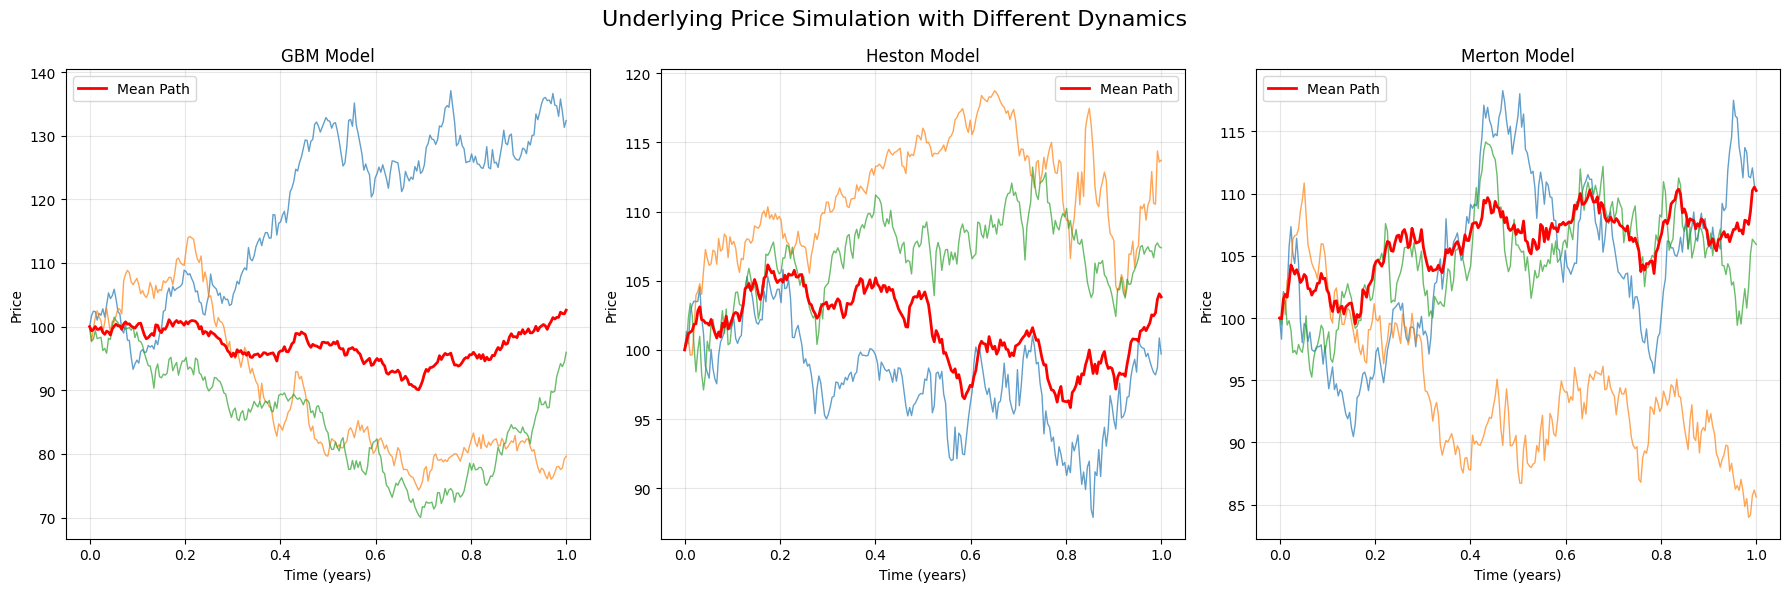

GBM Model Statistics:
  Final Price Range: $78.60 - $156.57
  Mean Final Price: $109.91
  Volatility: 16.99%
  Sharpe Ratio: 0.451
Heston Model Statistics:
  Final Price Range: $55.49 - $116.26
  Mean Final Price: $83.92
  Volatility: 18.77%
  Sharpe Ratio: -0.735
Merton Model Statistics:
  Final Price Range: $81.06 - $140.56
  Mean Final Price: $109.91
  Volatility: 17.29%
  Sharpe Ratio: 0.521


In [11]:
def demo_underlying_simulation():
    # Parameters
    S0 = 100
    T = 1.0
    n_steps = 252
    n_paths = 5
    
    # Create different dynamics models
    models = {
        'GBM': create_dynamics_model('GBM', mu=0.05, sigma=0.2),
        'Heston': create_dynamics_model('Heston', mu=0.05, kappa=2.0, theta=0.04, sigma_v=0.3, rho=-0.7),
        'Merton': create_dynamics_model('Merton', mu=0.05, sigma=0.2, lambda_jump=0.1, mu_jump=-0.1, sigma_jump=0.1)
    }
    
    # Simulate and plot paths
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Underlying Price Simulation with Different Dynamics', fontsize=16)
    
    for i, (name, model) in enumerate(models.items()):
        simulator = PriceSimulator(model)
        
        if name == 'Heston':
            S, v, t = simulator.simulate_paths(S0, T, n_steps, n_paths)
            # Plot price paths
            for j in range(min(3, S.shape[0])):
                axes[i].plot(t, S[j], alpha=0.7, linewidth=1)
            axes[i].plot(t, np.mean(S, axis=0), 'r-', linewidth=2, label='Mean Path')
        else:
            S, t = simulator.simulate_paths(S0, T, n_steps, n_paths)
            # Plot price paths
            for j in range(min(3, S.shape[0])):
                axes[i].plot(t, S[j], alpha=0.7, linewidth=1)
            axes[i].plot(t, np.mean(S, axis=0), 'r-', linewidth=2, label='Mean Path')
        
        axes[i].set_title(f'{name} Model')
        axes[i].set_xlabel('Time (years)')
        axes[i].set_ylabel('Price')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    for name, model in models.items():
        simulator = PriceSimulator(model)
        if name == 'Heston':
            S, v, t = simulator.simulate_paths(S0, T, n_steps, n_paths)
        else:
            S, t = simulator.simulate_paths(S0, T, n_steps, n_paths)
        
        stats = simulator.get_statistics(S, t)
        print(f"{name} Model Statistics:")
        print(f"  Final Price Range: ${stats['min_price']:.2f} - ${stats['max_price']:.2f}")
        print(f"  Mean Final Price: ${stats['mean_final_price']:.2f}")
        print(f"  Volatility: {stats['volatility'].mean():.2%}")
        print(f"  Sharpe Ratio: {stats['sharpe_ratio']:.3f}")

demo_underlying_simulation()

**OPTION PRICING**

In [12]:
def demo_option_pricing():
    # Parameters
    S0 = 100
    K = 100
    T = 0.25
    r = 0.05
    sigma = 0.25
    
    print(f"Parameters:")
    print(f"  S0: ${S0}")
    print(f"  K: ${K}")
    print(f"  T: {T} years")
    print(f"  r: {r:.2%}")
    print(f"  σ: {sigma:.2%}")
    
    # Test pricing with different dynamics models
    dynamics_models = {
        'GBM': create_dynamics_model('GBM', mu=r, sigma=sigma),
        'Heston': create_dynamics_model('Heston', mu=r, kappa=2.0, theta=sigma**2, sigma_v=0.3, rho=-0.7),
        'Merton': create_dynamics_model('Merton', mu=r, sigma=sigma, lambda_jump=0.1, mu_jump=-0.1, sigma_jump=0.1)
    }
    
    for model_name, dynamics_model in dynamics_models.items():
        print(f"Testing with {model_name} dynamics:")
        
        try:
            # Compare pricing models with this dynamics model
            results = compare_pricing_models(S0, K, T, r, dynamics_model)
            
            print(f"Pricing Results:")
            for pricing_model, result in results.items():
                if 'call' in result:
                    print(f"    {pricing_model} Call: ${result['call']:.4f}")
                if 'put' in result:
                    print(f"    {pricing_model} Put: ${result['put']:.4f}")
                if 'call_std_error' in result:
                    print(f"    {pricing_model} Call Std Error: ${result['call_std_error']:.4f}")
                    print(f"    {pricing_model} Put Std Error: ${result['put_std_error']:.4f}")
                    
        except Exception as e:
            print(f"Error with {model_name}: {e}")
demo_option_pricing()

Parameters:
  S0: $100
  K: $100
  T: 0.25 years
  r: 5.00%
  σ: 25.00%
Testing with GBM dynamics:
Pricing Results:
    Black-Scholes Call: $5.5984
    Black-Scholes Put: $4.3562
    Monte Carlo Call: $5.5374
    Monte Carlo Put: $4.2912
    Monte Carlo Call Std Error: $0.0822
    Monte Carlo Put Std Error: $0.0630
    Binomial Tree Call: $5.6897
    Binomial Tree Put: $4.3050
    Trinomial Tree Call: $5.5898
    Trinomial Tree Put: $4.3457
    Finite Difference (Explicit) Call: $5.4548
    Finite Difference (Explicit) Put: $4.4441
    Finite Difference (Implicit) Call: $5.6193
    Finite Difference (Implicit) Put: $4.4352
    Finite Difference (Crank-Nicolson) Call: $5.7214
    Finite Difference (Crank-Nicolson) Put: $4.3137
Testing with Heston dynamics:
Pricing Results:
    Monte Carlo Call: $4.8756
    Monte Carlo Put: $3.5917
    Monte Carlo Call Std Error: $0.0624
    Monte Carlo Put Std Error: $0.0602
    Binomial Tree Call: $4.7164
    Binomial Tree Put: $3.5149
    Trinomial Tr

Fetching market data for AAPL...
Fetched 106 options from market

📊 Model vs Market Price Comparison Summary
Black-Scholes:
  Mean Absolute Error: $4.7644
  Mean Absolute Percentage Error: 8252.70%
  Correlation with Market: 0.9887

Monte Carlo:
  Mean Absolute Error: $4.8087
  Mean Absolute Percentage Error: 8269.30%
  Correlation with Market: 0.9886

Binomial Tree:
  Mean Absolute Error: $4.7674
  Mean Absolute Percentage Error: 8246.36%
  Correlation with Market: 0.9887

Market Data Summary:
  Number of Options: 106
  Price Range: $0.01 - $116.77
  Strike Range: $110.00 - $325.00


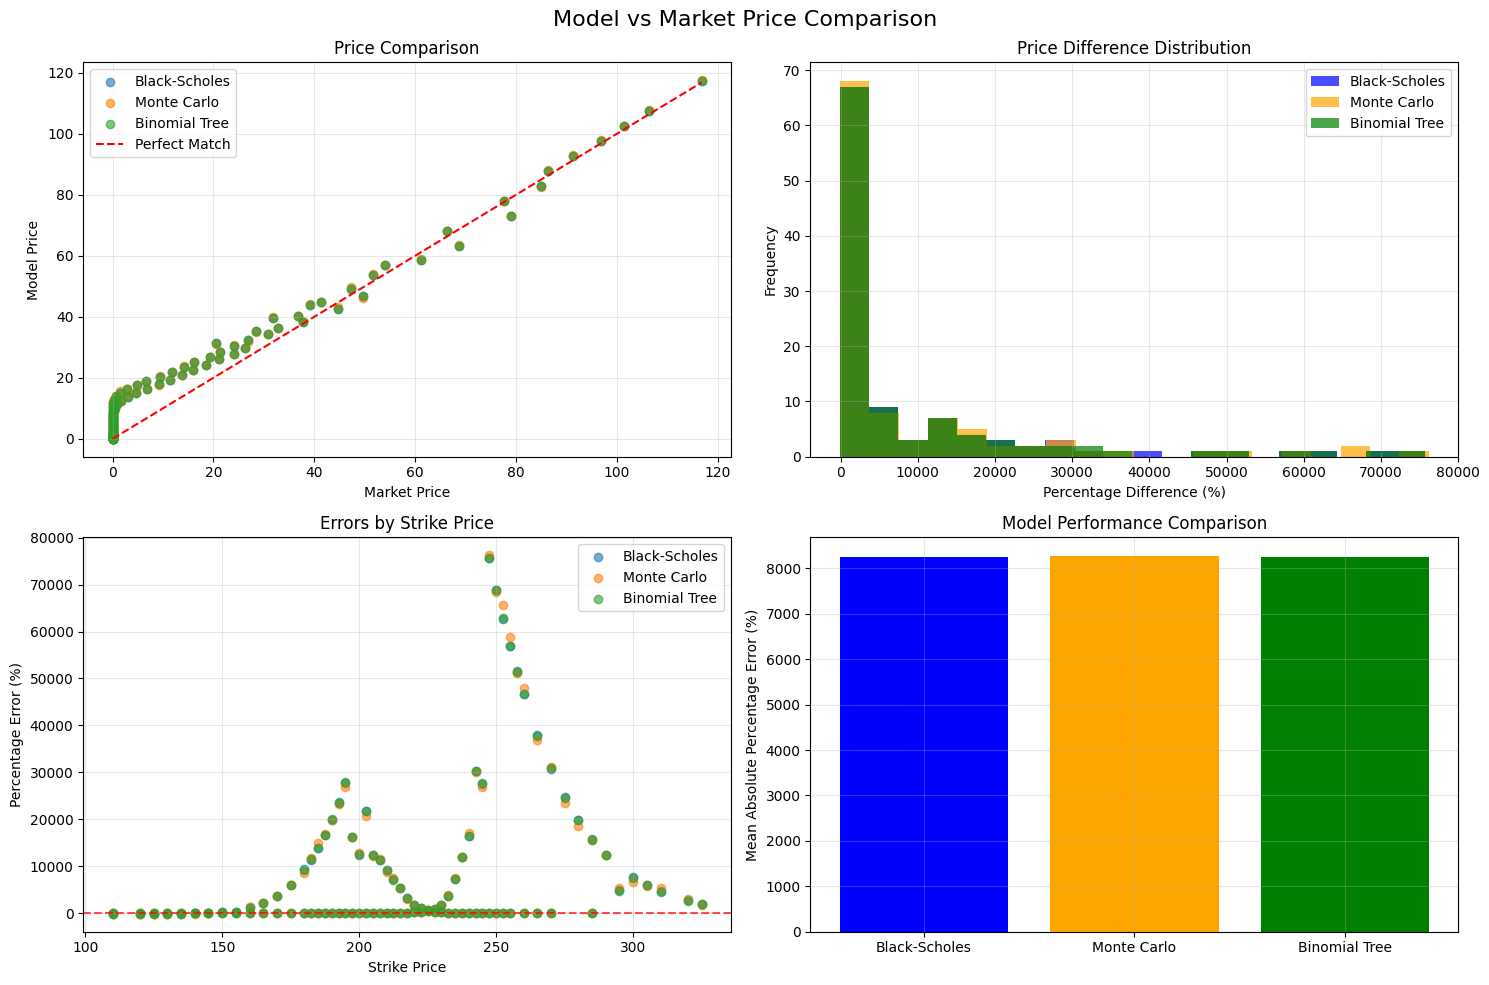

In [13]:
def demo_market_comparison():
    # Try to fetch real market data
    ticker = "AAPL"
    print(f"Fetching market data for {ticker}...")
    
    try:
        market_data = fetch_market_data(ticker, max_expiries=1)
        
        if not market_data['options'].empty:
            print(f"Fetched {len(market_data['options'])} options from market")
            
            # Prepare data for comparison
            options_data = market_data['options'].copy()
            options_data['time_to_expiry'] = 0.25  # Assume 3 months for demo
            
            # Compare prices
            comparator = ModelMarketComparator(market_data['current_price'])
            comparison_data = comparator.compare_prices(options_data, market_data['volatility'])
            
            # Print summary
            comparator.print_summary(comparison_data)
            
            # Plot comparison
            comparator.plot_comparison(comparison_data)
            
        else:
            print("No market data available")
            
    except Exception as e:
        print(f"Error fetching market data: {e}")

demo_market_comparison()

In [14]:
def demo_greeks_analysis():
    # Parameters
    S0 = 100
    strikes = np.linspace(80, 120, 20)
    T = 0.25
    r = 0.05
    sigma = 0.25
    
    # Create GBM dynamics model for Greeks calculation
    gbm_model = create_dynamics_model('GBM', mu=r, sigma=sigma)
    
    print(f"Greeks Analysis Summary:")
    print(f"  Number of Options: {len(strikes) * 2}")  # Calls and puts
    print(f"  Strike Range: ${strikes.min():.2f} - ${strikes.max():.2f}")
    
    # Calculate Greeks for a few representative options
    sample_strikes = [90, 100, 110]
    print(f"Sample Greeks (T={T}, r={r:.2%}, σ={sigma:.2%}):")
    
    for K in sample_strikes:
        # Call option
        bs_call = BlackScholes(S0, K, T, r, sigma)
        call_greeks = bs_call.calculate_greeks()
        
        # Put option  
        bs_put = BlackScholes(S0, K, T, r, sigma)
        put_greeks = bs_put.calculate_greeks()
        
        print(f"\n  Strike ${K}:")
        print(f"    Call - Delta: {call_greeks['delta_call']:.4f}, Gamma: {call_greeks['gamma']:.6f}, Vega: {call_greeks['vega']:.2f}")
        print(f"    Put  - Delta: {put_greeks['delta_put']:.4f}, Gamma: {put_greeks['gamma']:.6f}, Vega: {put_greeks['vega']:.2f}")
demo_greeks_analysis()

Greeks Analysis Summary:
  Number of Options: 40
  Strike Range: $80.00 - $120.00
Sample Greeks (T=0.25, r=5.00%, σ=25.00%):

  Strike $90:
    Call - Delta: 0.8426, Gamma: 0.019253, Vega: 12.03
    Put  - Delta: -0.1574, Gamma: 0.019253, Vega: 12.03

  Strike $100:
    Call - Delta: 0.5645, Gamma: 0.031497, Vega: 19.69
    Put  - Delta: -0.4355, Gamma: 0.031497, Vega: 19.69

  Strike $110:
    Call - Delta: 0.2743, Gamma: 0.026658, Vega: 16.66
    Put  - Delta: -0.7257, Gamma: 0.026658, Vega: 16.66


Fetching market data for AAPL...
Fetched 1008 options from market
  Calls: 537 options
  Puts: 471 options
  Current Price: $226.01
  Market Volatility: 32.08%
  Available columns: ['contractSymbol', 'lastTradeDate', 'strike', 'lastPrice', 'bid', 'ask', 'change', 'percentChange', 'volume', 'openInterest', 'impliedVolatility', 'inTheMoney', 'contractSize', 'currency', 'option_type', 'expiry_date', 'T', 'implied_volatility']
  Sample data shape: (1008, 18)
  Sample data:
   strike  lastPrice option_type expiry_date
0   110.0     116.77        call  2025-08-22
1   120.0     106.25        call  2025-08-22
2   125.0     101.30        call  2025-08-22
  'T' column sample: [0.0, 0.0, 0.0]
Call Options Volatility Analysis:

  Expiry: 0.00 years (0.0 months)
    Could not calculate implied volatilities for this expiry

  Expiry: 0.02 years (0.2 months)
    Strike Range: $110.00 - $325.00
    Vol Range: 0.2849 - 0.6104
    Mean Vol: 0.3670


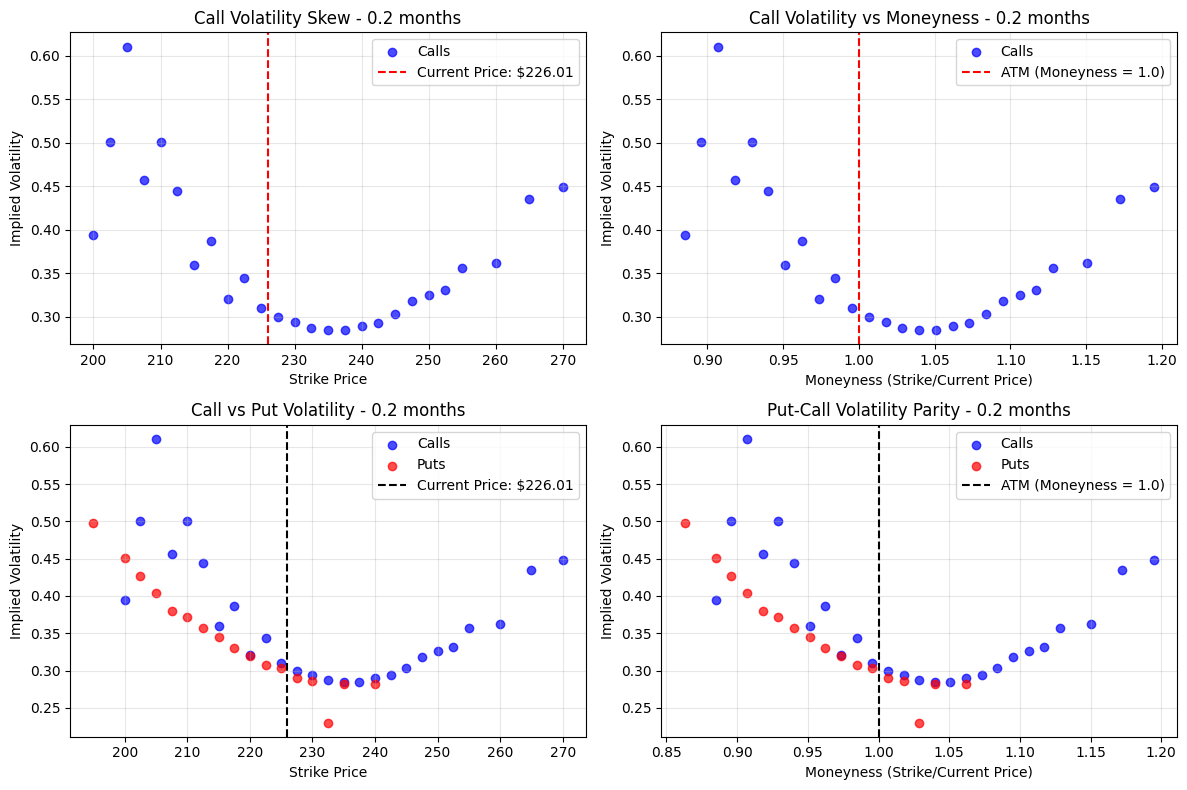

    ATM Volatility (0.98-1.02): 0.3119
    ITM Volatility (<0.95): 0.4845
    OTM Volatility (>1.05): 0.3408
    Volatility Skew (OTM - ATM): 0.0289
\Summary:
  Total Options: 1008
  Current Price: $226.01
  Market Volatility: 32.08%
  Volatility Smile Data Available: 537 call strikes


In [15]:
def demo_volatility_analysis():
    # Try to fetch real market data
    ticker = "AAPL"  
    print(f"Fetching market data for {ticker}...")
    
    try:
        market_data = fetch_market_data(ticker, max_expiries=10)
        
        if not market_data['options'].empty:
            print(f"Fetched {len(market_data['options'])} options from market")
            
            # Filter for calls and puts separately to analyze volatility skew
            calls = market_data['options'][market_data['options']['option_type'] == 'call']
            puts = market_data['options'][market_data['options']['option_type'] == 'put']
            
            print(f"  Calls: {len(calls)} options")
            print(f"  Puts: {len(puts)} options")
            print(f"  Current Price: ${market_data['current_price']:.2f}")
            print(f"  Market Volatility: {market_data['volatility']:.2%}")
            
            # Check what columns we actually have
            print(f"  Available columns: {list(market_data['options'].columns)}")
            print(f"  Sample data shape: {market_data['options'].shape}")
            if not market_data['options'].empty:
                print(f"  Sample data:")
                print(market_data['options'][['strike', 'lastPrice', 'option_type', 'expiry_date']].head(3))
                if 'T' in market_data['options'].columns:
                    print(f"  'T' column sample: {market_data['options']['T'].head(3).tolist()}")
            
            # Analyze volatility skew for calls
            if not calls.empty:
                print(f"Call Options Volatility Analysis:")
                calls['moneyness'] = calls['strike'] / market_data['current_price']
                
                # Use 'T' column if it exists (created by OptionChainAnalyzer), otherwise calculate from expiry_date
                if 'T' in calls.columns:
                    calls['time_to_expiry'] = calls['T']
                elif 'expiry_date' in calls.columns:
                    # Calculate time to expiry from expiry_date
                    calls['expiry_date'] = pd.to_datetime(calls['expiry_date'])
                    today = pd.Timestamp.now()
                    calls['time_to_expiry'] = (calls['expiry_date'] - today).dt.days / 365
                else:
                    # Default to 3 months if no expiry information
                    calls['time_to_expiry'] = 0.25
                
                # Group by expiry and analyze skew
                for expiry in calls['time_to_expiry'].unique():
                    if pd.isna(expiry):
                        continue
                    
                    expiry_calls = calls[calls['time_to_expiry'] == expiry]
                    if len(expiry_calls) < 3:  # Need at least 3 points for meaningful analysis
                        continue
                    
                    print(f"\n  Expiry: {expiry:.2f} years ({expiry*12:.1f} months)")
                    
                    # Sort by strike for proper skew analysis
                    expiry_calls = expiry_calls.sort_values('strike')
                    
                    # Calculate implied volatility for each call
                    implied_vols = []
                    for _, row in expiry_calls.iterrows():
                        try:
                            iv = implied_volatility(
                                market_data['current_price'], row['strike'], row['time_to_expiry'], 
                                0.05, row['lastPrice'], 'call'
                            )
                            implied_vols.append(iv)
                        except:
                            implied_vols.append(np.nan)
                    
                    expiry_calls['implied_volatility'] = implied_vols
                    valid_vols = expiry_calls['implied_volatility'].dropna()
                    
                    if len(valid_vols) > 0:
                        print(f"    Strike Range: ${expiry_calls['strike'].min():.2f} - ${expiry_calls['strike'].max():.2f}")
                        print(f"    Vol Range: {valid_vols.min():.4f} - {valid_vols.max():.4f}")
                        print(f"    Mean Vol: {valid_vols.mean():.4f}")
                        
                        # Plot volatility skew for this expiry
                        plt.figure(figsize=(12, 8))
                        
                        # Plot calls
                        plt.subplot(2, 2, 1)
                        plt.scatter(expiry_calls['strike'], expiry_calls['implied_volatility'], 
                                  alpha=0.7, color='blue', label='Calls')
                        plt.xlabel('Strike Price')
                        plt.ylabel('Implied Volatility')
                        plt.title(f'Call Volatility Skew - {expiry*12:.1f} months')
                        plt.axvline(x=market_data['current_price'], color='red', linestyle='--', 
                                   label=f'Current Price: ${market_data["current_price"]:.2f}')
                        plt.legend()
                        plt.grid(True, alpha=0.3)
                        
                        # Plot moneyness
                        plt.subplot(2, 2, 2)
                        plt.scatter(expiry_calls['moneyness'], expiry_calls['implied_volatility'], 
                                  alpha=0.7, color='blue', label='Calls')
                        plt.xlabel('Moneyness (Strike/Current Price)')
                        plt.ylabel('Implied Volatility')
                        plt.title(f'Call Volatility vs Moneyness - {expiry*12:.1f} months')
                        plt.axvline(x=1.0, color='red', linestyle='--', label='ATM (Moneyness = 1.0)')
                        plt.legend()
                        plt.grid(True, alpha=0.3)
                        
                        # Plot puts if available
                        if not puts.empty:
                            # Also need to handle time_to_expiry for puts
                            if 'T' in puts.columns:
                                puts['time_to_expiry'] = puts['T']
                            elif 'expiry_date' in puts.columns:
                                puts['expiry_date'] = pd.to_datetime(puts['expiry_date'])
                                today = pd.Timestamp.now()
                                puts['time_to_expiry'] = (puts['expiry_date'] - today).dt.days / 365
                            else:
                                puts['time_to_expiry'] = 0.25
                            
                            expiry_puts = puts[puts['time_to_expiry'] == expiry]
                            if len(expiry_puts) >= 3:
                                expiry_puts['moneyness'] = expiry_puts['strike'] / market_data['current_price']
                                expiry_puts = expiry_puts.sort_values('strike')
                                
                                # Calculate implied volatility for puts
                                put_implied_vols = []
                                for _, row in expiry_puts.iterrows():
                                    try:
                                        iv = implied_volatility(
                                            market_data['current_price'], row['strike'], row['time_to_expiry'], 
                                            0.05, row['lastPrice'], 'put'
                                        )
                                        put_implied_vols.append(iv)
                                    except:
                                        put_implied_vols.append(np.nan)
                                
                                expiry_puts['implied_volatility'] = put_implied_vols
                                valid_put_vols = expiry_puts['implied_volatility'].dropna()
                                
                                if len(valid_put_vols) > 0:
                                    # Combined plot
                                    plt.subplot(2, 2, 3)
                                    plt.scatter(expiry_calls['strike'], expiry_calls['implied_volatility'], 
                                              alpha=0.7, color='blue', label='Calls')
                                    plt.scatter(expiry_puts['strike'], expiry_puts['implied_volatility'], 
                                              alpha=0.7, color='red', label='Puts')
                                    plt.xlabel('Strike Price')
                                    plt.ylabel('Implied Volatility')
                                    plt.title(f'Call vs Put Volatility - {expiry*12:.1f} months')
                                    plt.axvline(x=market_data['current_price'], color='black', linestyle='--', 
                                               label=f'Current Price: ${market_data["current_price"]:.2f}')
                                    plt.legend()
                                    plt.grid(True, alpha=0.3)
                                    
                                    # Put-call parity analysis
                                    plt.subplot(2, 2, 4)
                                    plt.scatter(expiry_calls['moneyness'], expiry_calls['implied_volatility'], 
                                              alpha=0.7, color='blue', label='Calls')
                                    plt.scatter(expiry_puts['moneyness'], expiry_puts['implied_volatility'], 
                                              alpha=0.7, color='red', label='Puts')
                                    plt.xlabel('Moneyness (Strike/Current Price)')
                                    plt.ylabel('Implied Volatility')
                                    plt.title(f'Put-Call Volatility Parity - {expiry*12:.1f} months')
                                    plt.axvline(x=1.0, color='black', linestyle='--', label='ATM (Moneyness = 1.0)')
                                    plt.legend()
                                    plt.grid(True, alpha=0.3)
                        
                        plt.tight_layout()
                        plt.show()
                        
                        # Analyze skew patterns
                        atm_calls = expiry_calls[expiry_calls['moneyness'].between(0.98, 1.02)]
                        itm_calls = expiry_calls[expiry_calls['moneyness'] < 0.95]
                        otm_calls = expiry_calls[expiry_calls['moneyness'] > 1.05]
                        
                        print(f"    ATM Volatility (0.98-1.02): {atm_calls['implied_volatility'].mean():.4f}" if not atm_calls.empty else "    ATM Volatility: No data")
                        print(f"    ITM Volatility (<0.95): {itm_calls['implied_volatility'].mean():.4f}" if not itm_calls.empty else "    ITM Volatility: No data")
                        print(f"    OTM Volatility (>1.05): {otm_calls['implied_volatility'].mean():.4f}" if not otm_calls.empty else "    OTM Volatility: No data")
                        
                        # Calculate skew
                        if not atm_calls.empty and not otm_calls.empty:
                            skew = otm_calls['implied_volatility'].mean() - atm_calls['implied_volatility'].mean()
                            print(f"    Volatility Skew (OTM - ATM): {skew:.4f}")
                        
                        break  # Only show first expiry for demo purposes
                    else:
                        print(f"    Could not calculate implied volatilities for this expiry")
            else:
                print("No call options available for analysis")
            
            # Summary statistics
            print(f"\Summary:")
            print(f"  Total Options: {len(market_data['options'])}")
            print(f"  Current Price: ${market_data['current_price']:.2f}")
            print(f"  Market Volatility: {market_data['volatility']:.2%}")
            
            if 'volatility_smile' in market_data and market_data['volatility_smile']:
                smile = market_data['volatility_smile']
                if 'calls' in smile and smile['calls']['strikes']:
                    print(f"  Volatility Smile Data Available: {len(smile['calls']['strikes'])} call strikes")
            
        else:
            print("No market data available")
            
    except Exception as e:
        print(f"Error fetching market data: {e}")

demo_volatility_analysis()

In [16]:
def demo_comprehensive_workflow():
    # Step 1: Choose dynamics model
    print("Choosing underlying dynamics model...")
    dynamics_model = create_dynamics_model('Heston', mu=0.05, kappa=2.0, theta=0.04, sigma_v=0.3, rho=-0.7)
    print(f"   Selected: {dynamics_model.get_parameters()['model']} model")
    
    # Step 2: Simulate underlying prices
    print("Simulating underlying price paths...")
    simulator = PriceSimulator(dynamics_model)
    S, v, t = simulator.simulate_paths(100, 1.0, 252, 1)
    print(f"   Simulated {len(t)} time steps, final price: ${S[0, -1]:.2f}")
    
    # Step 3: Price options using different models
    print("Pricing options using different models...")
    K = 100
    T = 0.25
    r = 0.05
    
    # Test different pricing approaches
    pricing_results = {}
    
    # Monte Carlo with Heston dynamics
    try:
        mc = MonteCarloPricer(100, K, T, r, dynamics_model)
        mc_call = mc.price_call()
        pricing_results['Monte Carlo (Heston)'] = mc_call['price']
        print(f"   Monte Carlo Call: ${mc_call['price']:.4f}")
    except Exception as e:
        print(f"   Monte Carlo failed: {e}")
    
    # Black-Scholes (GBM only)
    try:
        gbm_model = create_dynamics_model('GBM', mu=r, sigma=0.3)
        bs = BlackScholes(100, K, T, r, 0.3)
        pricing_results['Black-Scholes (GBM)'] = bs.price_call()
        print(f"   Black-Scholes Call: ${bs.price_call():.4f}")
    except Exception as e:
        print(f"   Black-Scholes failed: {e}")
    
    # Step 4: Calculate Greeks (for GBM models)
    print("Calculating option Greeks...")
    try:
        greeks = bs.calculate_greeks()
        print(f"Greeks (Call Option):")
        print(f"  Delta: {greeks['delta_call']:.4f}")
        print(f"  Gamma: {greeks['gamma']:.4f}")
        print(f"  Vega: {greeks['vega']:.4f}")
        print(f"  Theta: {greeks['theta_call']:.4f}")
        print(f"  Rho: {greeks['rho_call']:.4f}")
    except Exception as e:
        print(f"   Greeks calculation failed: {e}")
    
    # Step 5: Risk analysis
    print("Performing risk analysis...")
    final_prices = S[0, -1]
    if pricing_results:
        best_price = min(pricing_results.values())
        payoff = option_payoff(final_prices, K, 'call')
        print(f"Risk Analysis:")
        print(f"  Final Underlying Price: ${final_prices:.2f}")
        print(f"  Option Payoff: ${payoff:.2f}")
        print(f"  Profit/Loss: ${payoff - best_price:.4f}")
    
demo_comprehensive_workflow()

Choosing underlying dynamics model...
   Selected: Heston model
Simulating underlying price paths...
   Simulated 253 time steps, final price: $107.60
Pricing options using different models...
   Monte Carlo Call: $4.5864
   Black-Scholes Call: $6.5831
Calculating option Greeks...
Greeks (Call Option):
  Delta: 0.5629
  Gamma: 0.0263
  Vega: 19.6986
  Theta: -14.3045
  Rho: 12.4268
Performing risk analysis...
Risk Analysis:
  Final Underlying Price: $107.60
  Option Payoff: $7.60
  Profit/Loss: $3.0133
